Data von https://www.kaggle.com/thetrueboolean/ab-data



In [1]:
import pandas as pd
import numpy as np
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
sns.set_style(style = 'whitegrid')
sns.set(rc = {'figure.figsize': (12,8), 
             'axes.facecolor': 'white',
             'axes.grid': True,'grid.color': '.7',
             'axes.linewidth': 1.0, 
             'grid.linestyle': u'-'}, font_scale = 1.0)
custom_colors = ['#332288','#44AA99', '#54727d',  '#d39391', '#ffdb57'] #['#616063', '#513e5c', '#a9bcc6','#976f4f', '#616063', ] #b#d4c9c7 f#cec3eb #d4c9c7
sns.set_palette(custom_colors)

### A/B-Test
A/B-Test ist ein Experiment, welches ermöglicht, potenzielle Verbesserungen im Vergleich zu einer Originalversion zu testen.
Mit Hilfe einer statistischen Analyse zeigen wir in unserem Beispiel, ob eine Veränderung der Internetseite die Conversion-Rate fördert. 

Dataset enthält: 

+ die IDs von Benutzern

+ Zeitangabe zu dem Besuch der Internetseite,

+ die Gruppe, zu der sie Gehören, Kontrollgruppe oder Testgruppe

+ die Version von der Seite, die sie besucht haben (alte oder veränderte)

+ Conversion

### Die Exploration von Data

In [3]:
df = pd.read_csv('ab_data.csv', parse_dates = [1], index_col=1)
df.head()

,user_id,group,landing_page,converted
timestamp,,,,
2017-01-21 22:11:48.556739,851104,control,old_page,0
2017-01-12 08:01:45.159739,804228,control,old_page,0
2017-01-11 16:55:06.154213,661590,treatment,new_page,0
2017-01-08 18:28:03.143765,853541,treatment,new_page,0
2017-01-21 01:52:26.210827,864975,control,old_page,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 294478 entries, 2017-01-21 22:11:48.556739 to 2017-01-16 12:40:24.467417
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   group         294478 non-null  object
 2   landing_page  294478 non-null  object
 3   converted     294478 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 11.2+ MB


In [5]:
"""Prüfen, ob die Daten NaNs beinhalten"""
df.isna().sum()

user_id         0
group           0
landing_page    0
converted       0
dtype: int64

Prüfen, ob die Versionen der Gruppen korrekt angezeigt wurden: dass die "control" Gruppe nur die Version "old_page" bekommen hat, und die "treatment" Gruppe- die neue Version, also die "new_page":

In [6]:
df_check1= df.pivot_table(index=['group'], columns = ['landing_page'], values=['user_id'], aggfunc = 'count')

df_check1

user_id         
landing_page new_page old_page
group                         
control          1928   145274
treatment      145311     1965

Wahrscheinlich ist ein Fehler aufgetreten. Wir betrachten nur die korrekten Daten für den Test:


In [7]:
df = df.loc[(df.group == 'control') & (df.landing_page == 'old_page')|\
              (df.group == 'treatment') & (df.landing_page == 'new_page')]
df

,user_id,group,landing_page,converted
timestamp,,,,
2017-01-21 22:11:48.556739,851104,control,old_page,0
2017-01-12 08:01:45.159739,804228,control,old_page,0
2017-01-11 16:55:06.154213,661590,treatment,new_page,0
2017-01-08 18:28:03.143765,853541,treatment,new_page,0
2017-01-21 01:52:26.210827,864975,control,old_page,1
...,...,...,...,...
2017-01-03 22:28:38.630509,751197,control,old_page,0
2017-01-12 00:51:57.078372,945152,control,old_page,0
2017-01-22 11:45:03.439544,734608,control,old_page,0


In [8]:
"""Check-up"""
df.pivot_table(index=['group'], columns = ['landing_page'], values=['user_id'], aggfunc = 'count')

user_id          
landing_page  new_page  old_page
group                           
control            NaN  145274.0
treatment     145311.0       NaN

Sieht gut aus.

Angaben zu Konversion im Laufen der Zeit.

In [9]:
df['Tag'] = df.index.day
df.head()

,user_id,group,landing_page,converted,Tag
timestamp,,,,,
2017-01-21 22:11:48.556739,851104,control,old_page,0,21
2017-01-12 08:01:45.159739,804228,control,old_page,0,12
2017-01-11 16:55:06.154213,661590,treatment,new_page,0,11
2017-01-08 18:28:03.143765,853541,treatment,new_page,0,8
2017-01-21 01:52:26.210827,864975,control,old_page,1,21


In [10]:
konv_control = df.loc[(df.group == 'control') & (df.landing_page == 'old_page')&(df.converted == 1)].sort_values('Tag')
konv_treatment = df.loc[(df.group == 'treatment') & (df.landing_page == 'new_page')&(df.converted == 1)].sort_values('Tag')


In [11]:
konversion = pd.DataFrame(konv_control.groupby('Tag')['converted'].count())
kon_treat = pd.DataFrame(konv_treatment.groupby('Tag')['converted'].count())
konversion['Test'] = kon_treat['converted']
konversion.columns = ['Kontrol', 'Test']
konversion.tail()

,Kontrol,Test
Tag,,
20,753,786
21,850,759
22,786,787
23,844,803
24,443,448


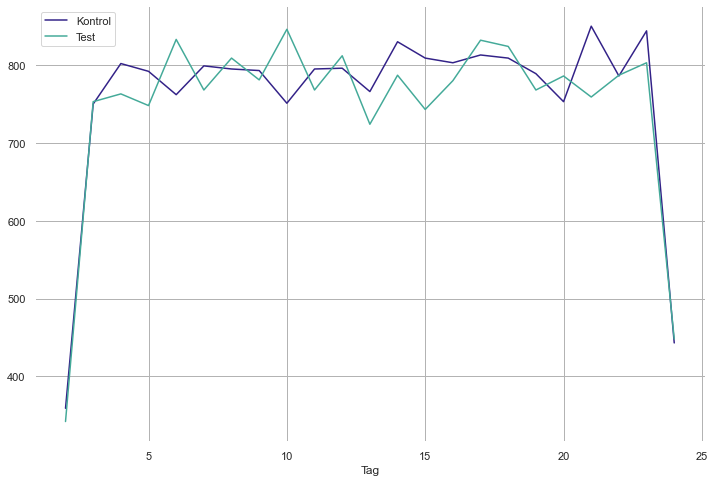

In [12]:
konversion.plot();

### Konversionsrate in beiden Gruppen:

In [13]:
gruppen = df.pivot_table(index = 'group', columns = ['landing_page', 'converted'], values=['user_id'], aggfunc = 'count').droplevel(level = [0,2], axis=1)

In [14]:
gruppen

landing_page,new_page,new_page,old_page,old_page
group,,,,
control,NaN,NaN,127785.0,17489.0
treatment,128047.0,17264.0,NaN,NaN


In [15]:
control = gruppen.iloc[0,[2,3]]
treatment = gruppen.iloc[1,[0,1]]

In [16]:
control

landing_page
old_page    127785.0
old_page     17489.0
Name: control, dtype: float64

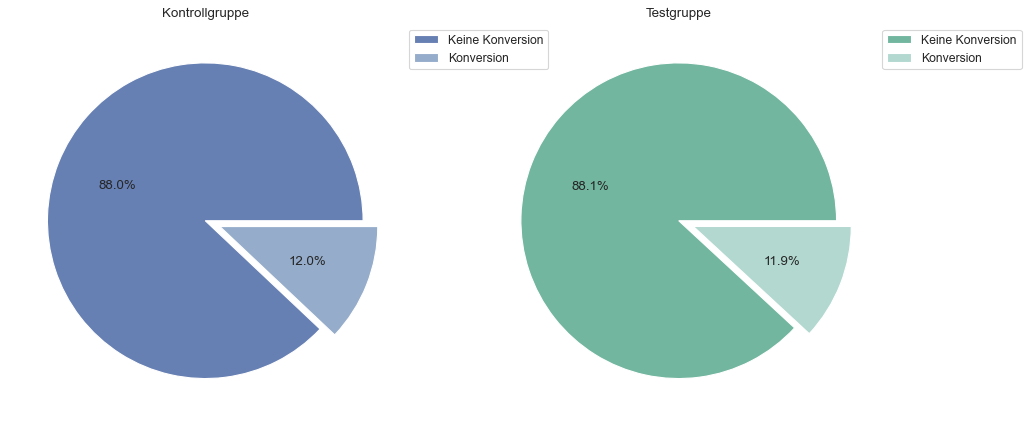

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,8), dpi= 80)


colors_o = ['#6780b3', '#95acca']
colors_n = ['#72b6a0', '#b2d8cf']

labels = ['Keine Konversion','Konversion']

explode = (0,0.1)
ax1.pie(control, colors = colors_o, autopct='%1.1f%%', explode=explode)
ax2.pie(treatment, colors = colors_n, autopct='%1.1f%%', explode=explode)

ax1.legend( labels, loc="upper left", bbox_to_anchor=(1, 0, 0.3, 1))  
ax2.legend( labels, loc="upper left", bbox_to_anchor=(1, 0, 0.3, 1)) 

ax1.set_title('Kontrollgruppe')
ax2.set_title('Testgruppe')
plt.show()

Konversionsrate in der Kontrollgruppe ist gleich 12%, in der Testgruppe: 11,9%. Sieht so aus, als ob die Veränderte Version den Nutzern weniger gefallen hat. Dies wollen wir noch statistisch beweisen.


### Hypothesen formulieren:

Bei der Nullhypotese gehen wir davon aus, dass die eine Variante des Systems keine Veränderung verursacht. Die Alternativhypotese basiert auf der Annahme, dass die neue Variante eine bessere Conversion-Rate fördert, dass die Conversion-Rate in der Testgruppe höher ist.

$$  H_0:  CR_1 = CR_2 $$

$$ H_1:  CR_1 > CR_2  $$



Bestimmen von einer statistischen Signifikanz.
Wir wollen bestimmen, wie hoch ist das Risiko, welches wir bereit sind einzugehen, eine falsche Eintscheidung zu treffen. In unserem Fall: dass die Conversion-Rate nun zuvällig höher ist und nicht mit einer veränderten Version verbunden ist.

Wir nehmen die Wahrscheinlichkeit der üblichen 95%, dass unser Ergebnis statistisch signifikant ist ( $\alpha$ = 0.05)

Da wir mit diskreten Daten arbeiten, nutzen wir für die Berechnung den Chi-Quadrat-Test.

Wenn **p_value < $\alpha$**:  es gibt keinen Grund die Nullhypothese abzulehnen.

In [21]:
alpha = 0.05

In [22]:
import statsmodels.stats.proportion as proportion

In [23]:
#??proportion.proportions_chisquare

Parameters:
count: {int, array_like}
         die Anzahl der Erfolge in Nobs-Prozessen
         
nobs: ist
         die Anzahl der Versuche oder Beobachtungen         
         
         

In [24]:
tab_chi2= pd.crosstab(df.landing_page, df.converted, normalize = False)
tab_chi2

converted,0,1
landing_page,,
new_page,128047,17264
old_page,127785,17489


In [25]:
tab_chi = tab_chi2.copy()
tab_chi['gesamt'] = tab_chi.sum(axis=1)
tab_chi.columns= ['no_conv','conv','gesamt']
tab_chi

,no_conv,conv,gesamt
landing_page,,,
new_page,128047,17264,145311
old_page,127785,17489,145274


In [26]:
df_chi =pd.DataFrame(tab_chi[['conv', 'gesamt']])
df_chi

,conv,gesamt
landing_page,,
new_page,17264,145311
old_page,17489,145274


In [27]:
chistat, p_value, tabelle = proportion.proportions_chisquare(tab_chi['conv'], tab_chi['gesamt'])
print('Chi-Quadrat = %.2f, p_value = %.2f' % (chistat,p_value))

Chi-Quadrat = 1.72, p_value = 0.19


In [28]:
print(p_value<alpha)

False


Somit ist die Nullhypothese nicht abzulehnen. Eine Variante der Internetseite hat keine Veränderung verursacht und nicht zur Förderung der Conversion_Rate gefürt. 